
# Stock Market Dataset

In this kernel, we will design and train the model we will use in our web app. We will develop a Long Short-Term Memory (LSTM) Neural Network and harness its capability to solve problems in time series. This model will take as input Closing Stock Prices of previous days and predict the next days Stock Prices.


In [1]:
import yfinance as yf

import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback


# Pre-Processing

In [2]:
df = yf.download("TSLA")
df.index.name = None
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...
2020-11-09,439.500000,452.500000,421.000000,421.260010,421.260010,34833000
2020-11-10,420.089996,420.089996,396.029999,410.359985,410.359985,30284200
2020-11-11,416.450012,418.700012,410.579987,417.130005,417.130005,17357700
2020-11-12,415.049988,423.000000,409.519989,411.760010,411.760010,19855100


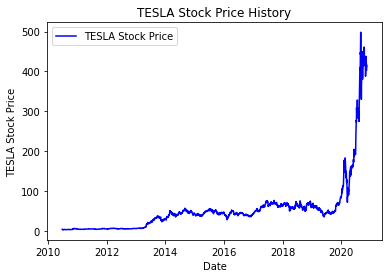

In [3]:
# Visualising the data
plt.plot(df.index, df.iloc[:, 3:4], color = 'b', label = 'TESLA Stock Price')
plt.title('TESLA Stock Price History')
plt.xlabel('Date')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [4]:
# 75-25 Train-Test Split
train_set = df.iloc[:int(df.shape[0]*.75), 3:4].values
test_set = df.iloc[int(df.shape[0]*.75):, 3:4].values

In [5]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.transform(test_set)

In [6]:
# Raw closing stock price
input_len = 60
output_len = 1

def split_data_prices_in_windows(df):
    """
    Create series of "input_len" Closing prices and its coresponding  "output_len" price.    
    """
    LSTM_inputs = []
    LSTM_outputs = []
    for i in range(input_len, len(df)):
        # Process the model's input sequence
        historical_prices = df[i-input_len : i].copy()
        LSTM_inputs.append(np.array(historical_prices))
        
        # Process the model's expected output sequence
        target_price = df[i].copy()        
        LSTM_outputs.append(np.array(target_price))
        
    LSTM_inputs = np.array(LSTM_inputs)
    LSTM_outputs = np.array(LSTM_outputs)
    
    return LSTM_inputs, LSTM_outputs

x_train, y_train = split_data_prices_in_windows(train_set_scaled)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_test, y_test = split_data_prices_in_windows(test_set_scaled)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
# Shuffle data
x_train, y_train = shuffle(x_train, y_train)

# Model Design

In [ ]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')

In [ ]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
        
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [8]:
class LossHistory(Callback):
    def __init__(self):
        self.loss = []
        self.val_loss = []

    def on_batch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss.append(logs.get('loss'))
        
cb = LossHistory()

In [9]:
def LSTM_model(input_shape, output_shape, neurons, dropout):
    x = Input(shape=input_shape)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=False)(hidden)
    hidden = Dropout(dropout)(hidden)
    y = Dense(output_shape, activation='linear')(hidden)
    return Model(inputs=x, outputs=y)

model = LSTM_model((input_len, 1), output_len, 50, 0.2)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(optimizer=optimizer, metrics=['mse'], loss = 'mean_squared_error')

# Baseline
model.evaluate(x_test, y_test)

19/19 [==============================] - 0s 9ms/step - loss: 6.3565 - mse: 6.3565


[6.356457710266113, 6.3564581871032715]

In [ ]:


# find learning rate first
epoch_size = 20
batch_size = 256

lr_finder = LRFinder(min_lr=1e-4, 
                     max_lr=1e-2, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=3)
model.fit(LSTM_inputs, LSTM_outputs, callbacks=[lr_finder])

lr_finder.plot_loss()



In [ ]:
# Create the Learning Rate Scheduler Callback
schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-2,
                         steps_per_epoch=np.ceil(epoch_size/batch_size),
                         lr_decay=0.9,
                         cycle_length= 3,
                         mult_factor=1.5)

# Training

In [10]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test),
          epochs = 50, batch_size = 32, callbacks=[cb, schedule])

Epoch 1/50
60/60 [==============================] - 2s 41ms/step - loss: 0.0269 - mse: 0.0269 - val_loss: 1.5610 - val_mse: 1.5610
Epoch 2/50
60/60 [==============================] - 3s 42ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 1.4460 - val_mse: 1.4460
Epoch 3/50
60/60 [==============================] - 3s 45ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 1.3665 - val_mse: 1.3665
Epoch 4/50
60/60 [==============================] - 3s 44ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 1.2937 - val_mse: 1.2937
Epoch 5/50
60/60 [==============================] - 3s 42ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 1.2016 - val_mse: 1.2016
Epoch 6/50
60/60 [==============================] - 3s 44ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 1.2235 - val_mse: 1.2235
Epoch 7/50
60/60 [==============================] - 3s 44ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 1.1244 - val_mse: 1.1244
Epoch 8/50
60/60 [==============================] - 2s 40ms/step - loss: 0.0026 - m

# Evaluation

In [11]:
model.evaluate(x_test, y_test)

19/19 [==============================] - 0s 10ms/step - loss: 0.3263 - mse: 0.3263


[0.32628974318504333, 0.32628974318504333]

Text(0.5, 0, 'Epoch')

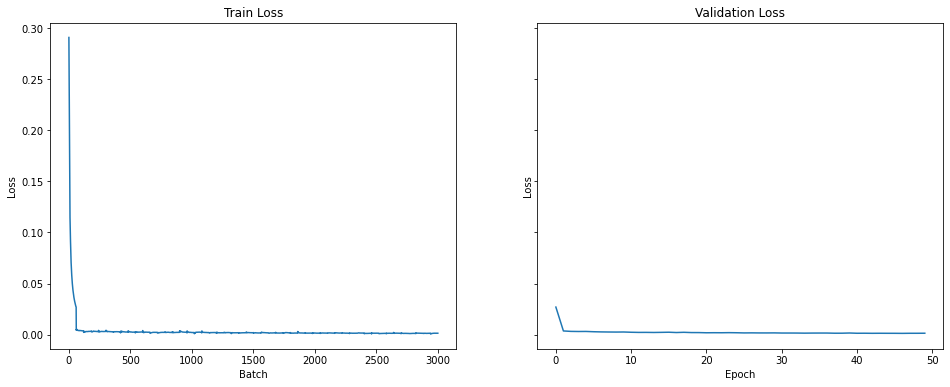

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.plot(cb.loss)
ax1.set_title('Train Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Batch')
ax2.plot(cb.val_loss)
ax2.set_title('Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

In [13]:
predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

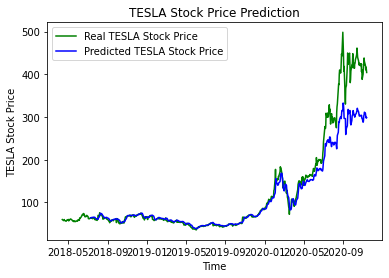

In [14]:
# Visualising the results
plt.plot(df.index[int(df.shape[0]*.75):], df.iloc[int(df.shape[0]*.75):, 3:4],
         color = 'green', label = 'Real TESLA Stock Price')
plt.plot(df.index[60+int(df.shape[0]*.75):], predicted_stock_price,
         color = 'red', label = 'Predicted TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()